In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import os
import sys


import bcolz

import pandas as pd
import bcolz
#from pymongo import MongoClient
import xarray as xr

from tqdm import tqdm
import threading
from floater.generators import FloatSet
from floater import hexgrid
from helper import bcolz_to_array, dataseries_to_array, region_to_json

from matplotlib.colors import LogNorm

In [2]:
def latlon_2_xy(lon_deg,lat_deg):
    lat = np.radians(lat_deg)
    lon = np.radians(lon_deg)
    R = 6370.0e3
    y = R*lat
    x = R*np.cos(lat)*lon
    return x,y

def calc_flow_map(bcolz_dir, floatset):
    bc = bcolz.open(rootdir=bcolz_dir)
    df = bc.todataframe()
    times = df.time.unique()
    fs = floatset
    X1, Y1 = bcolz_to_array(times.max(), bc, fs, colname=['x', 'y'], drop_duplicates=True)
    X0, Y0 = bcolz_to_array(times.min(), bc, fs, colname=['x', 'y'], drop_duplicates=True)
    lav_index_npart = df.where(df.vort>-999).groupby('npart')['vort'].mean()
    lav = dataseries_to_array(lav_index_npart, fs)

    delta = 0.1
    xmax, xmin = df.x.max()-delta, df.x.min()+delta
    ymax, ymin = df.y.max()-delta, df.y.min()+delta
    mask = (df.x > xmax) | (df.x < xmin) | (df.y > ymax) | (df.y < ymin)

    avg_count_series = df[~mask].where(df.vort>-999).groupby('npart')['vort'].count()
    cnt = dataseries_to_array(avg_count_series, fs)
    lav_mask = (cnt<cnt.max())

    return (X0, Y0, X1, Y1, lav_mask)

In [5]:
dir1 = '/data/scratch/as4479/llc_run_s_2/trajectories_fewer_fields.bcolz/'
dir2 = '/data/scratch/as4479/llc_run_s_3/trajectories_fewer_fields.bcolz/'
dir3 = '/data/scratch/as4479/llc_run3_s2/trajectories_fewer_fields.bcolz/'
dir4 = '/data/scratch/as4479/llc_run3_s3_2/trajectories_fewer_fields.bcolz/'
figdir = 'figures4/'

#case = ['llc_run2_s_2','llc_run3_s2','llc_run_s_2','llc_run_s_3', 'llc_run3_s3']
case = ['llc_run_s_2','llc_run_s_3','llc_run3_s2','llc_run3_s3',]
cases = ['2d float, dT = 25','3d float, dT = 25','2d float, dT = 100','3d float, dT = 100']

floatset = FloatSet((-60.,-50.), (33.,40.5), dx = 0.02, dy = 0.015)

bcolz_dir = [dir1, dir2, dir3, dir4]

In [6]:
def delta_F(X0,X1,Y0,Y1):
    deltaX = X1 - X0
    deltaY = Y1 - Y0
    return deltaX, deltaY

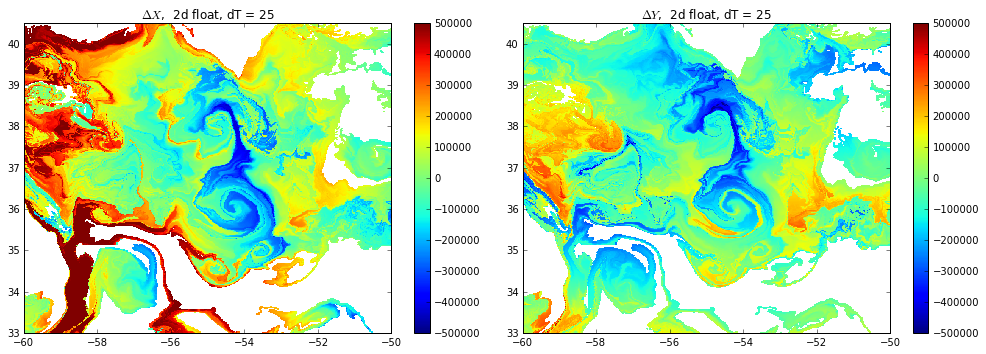

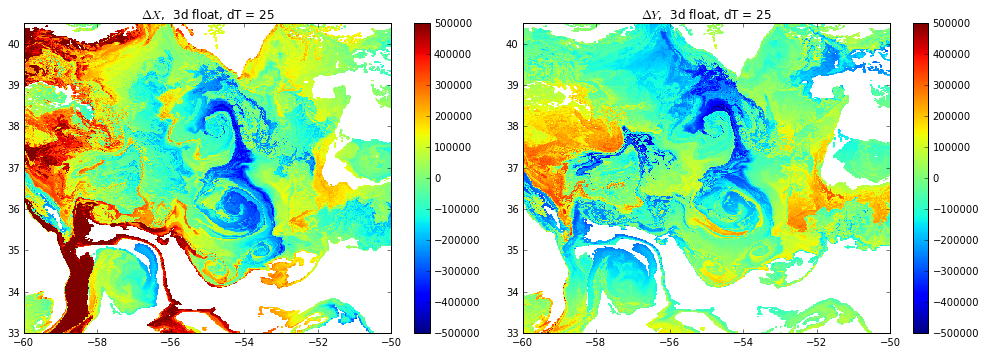

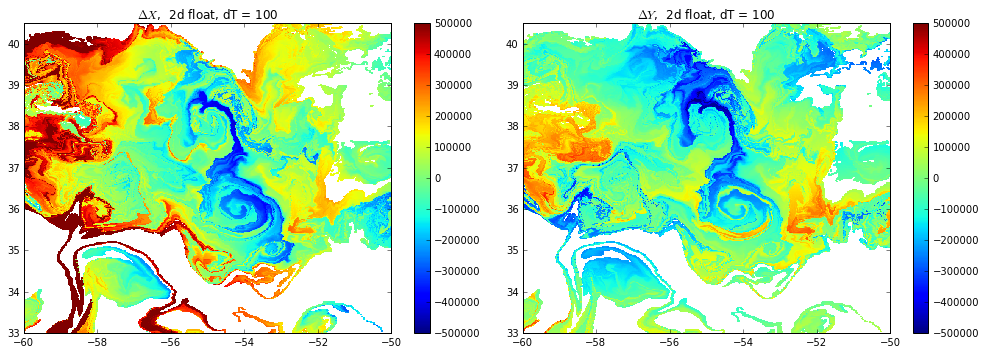

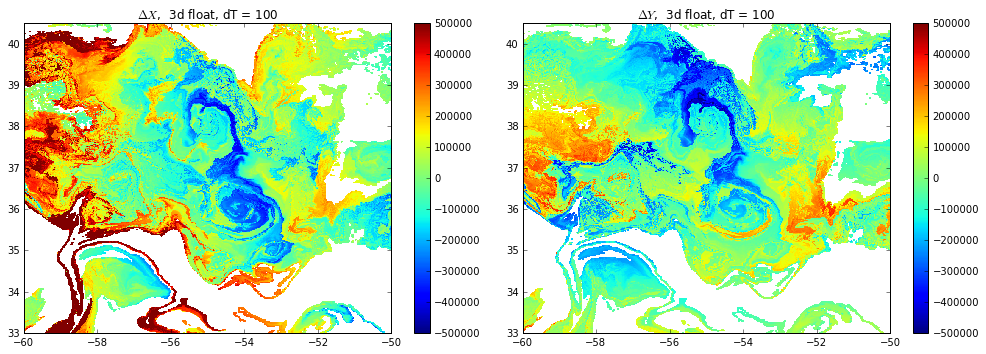

In [8]:
Fl_map = np.zeros((len(bcolz_dir),2,floatset.Nx,floatset.Ny))
lav_mask = np.zeros((len(bcolz_dir),floatset.Nx,floatset.Ny))

for i in range(len(bcolz_dir)):
    bc_dir = bcolz_dir[i]
    x0, y0, x1, y1, mask = calc_flow_map(bc_dir, floatset)
    X0,Y0 = latlon_2_xy(x0,y0)
    X1,Y1 = latlon_2_xy(x1,y1)
    lav_mask[i] = mask

    Fl_map1 = delta_F(X0,X1,Y0,Y1)
    Fl_map[i,0] = Fl_map1[0]
    Fl_map[i,1] = Fl_map1[1]
    
    fig = plt.figure(figsize=(14,5))
    plt.subplot(121)
    plt.pcolormesh(x0,y0,np.ma.masked_array(Fl_map[i,0], lav_mask[i]));
    plt.title(r'$\Delta X$,  %s' %cases[i])
    plt.clim([-500000.,500000.])
    plt.xlim([x0.min(),x0.max()])
    plt.ylim([y0.min(),y0.max()])
    plt.colorbar()
    
    plt.subplot(122)
    plt.pcolormesh(x0,y0,np.ma.masked_array(Fl_map[i,1], lav_mask[i]));
    plt.title(r'$\Delta Y$,  %s' %cases[i])
    plt.clim([-500000.,500000.])
    plt.xlim([x0.min(),x0.max()])
    plt.ylim([y0.min(),y0.max()])
    plt.colorbar()
    
    plt.tight_layout()
    
    fig.savefig(figdir+'Flowmap_%s' %case[i])

In [9]:
def error_deltaF(deltaF1, deltaF2, normalize = True):
    if normalize==False:
        error_deltaF =np.sqrt((deltaF1[0] - deltaF2[0])**2 
                          + (deltaF1[1] - deltaF2[1])**2)
    else:
        error_deltaF =np.sqrt((deltaF1[0] - deltaF2[0])**2 
                          + (deltaF1[1] - deltaF2[1])**2)/np.sqrt((deltaF1[0])**2 + (deltaF1[1])**2 )
    return error_deltaF

In [10]:
lav_mask_1 = np.ma.mask_or(lav_mask[0],lav_mask[1])
lav_mask_2 = np.ma.mask_or(lav_mask[0],lav_mask[2])
lav_mask_3 = np.ma.mask_or(lav_mask[0],lav_mask[3])
lav_mask_4 = np.ma.mask_or(lav_mask[1],lav_mask[2])
lav_mask_5 = np.ma.mask_or(lav_mask[1],lav_mask[3])
lav_mask_6 = np.ma.mask_or(lav_mask[2],lav_mask[3])

error_flowmap_1 = error_deltaF(Fl_map[0],Fl_map[1], normalize = False)
error_flowmap_2 = error_deltaF(Fl_map[0],Fl_map[2], normalize = False)
error_flowmap_3 = error_deltaF(Fl_map[0],Fl_map[3], normalize = False)
error_flowmap_4 = error_deltaF(Fl_map[1],Fl_map[2], normalize = False)
error_flowmap_5 = error_deltaF(Fl_map[1],Fl_map[3], normalize = False)
error_flowmap_6 = error_deltaF(Fl_map[2],Fl_map[3], normalize = False)


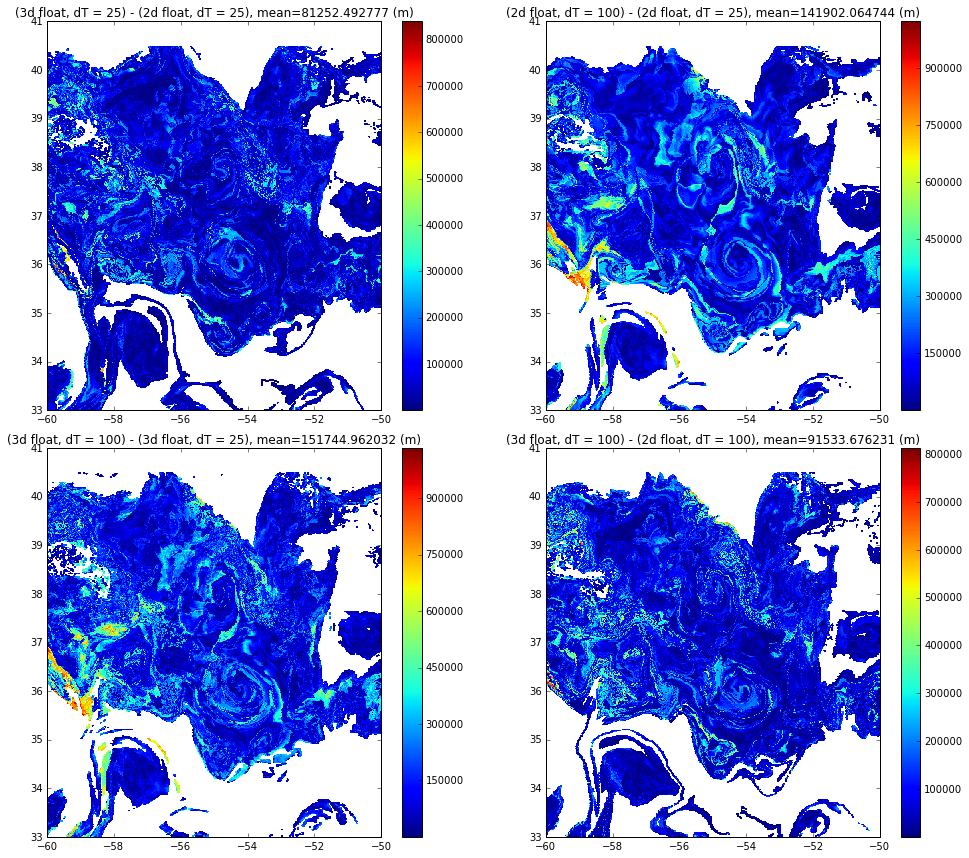

In [11]:
fig = plt.figure(figsize=(14,12))

plt.subplot(2,2,1)
plt.pcolormesh(x0,y0,np.ma.masked_array(error_flowmap_1,lav_mask_1))#, cmap = 'winter_r');
plt.title('(%s) - (%s), mean=%f (m)' %(cases[1], cases[0], np.mean(np.ma.masked_array(error_flowmap_1,lav_mask_1))))
#plt.clim([-800000.0,800000.0])
plt.colorbar()

plt.subplot(2,2,2)
plt.pcolormesh(x0,y0,np.ma.masked_array(error_flowmap_2,lav_mask_2))#, cmap = 'winter_r');
plt.title('(%s) - (%s), mean=%f (m)' %(cases[2], cases[0], np.mean(np.ma.masked_array(error_flowmap_2,lav_mask_2))))
#plt.clim([-800000.0,800000.0])
plt.colorbar()

plt.subplot(2,2,3)
plt.pcolormesh(x0,y0,np.ma.masked_array(error_flowmap_5,lav_mask_5))#, cmap = 'winter_r');
plt.title('(%s) - (%s), mean=%f (m)' %(cases[3], cases[1], np.mean(np.ma.masked_array(error_flowmap_5,lav_mask_5))))
#plt.clim([-800000.0,800000.0])
plt.colorbar()


plt.subplot(2,2,4)
plt.pcolormesh(x0,y0,np.ma.masked_array(error_flowmap_6,lav_mask_6))#, cmap = 'winter_r');
plt.title('(%s) - (%s), mean=%f (m)' %(cases[3], cases[2], np.mean(np.ma.masked_array(error_flowmap_6,lav_mask_6))))
#plt.clim([-800000.0,800000.0])
plt.colorbar()

plt.tight_layout()
fig.savefig(figdir+'Fl_map_diff_between_cases_wo_same_clim')

In [12]:
error_flowmap_1 = error_deltaF(Fl_map[0],Fl_map[1])
error_flowmap_2 = error_deltaF(Fl_map[0],Fl_map[2])
error_flowmap_3 = error_deltaF(Fl_map[0],Fl_map[3])
error_flowmap_4 = error_deltaF(Fl_map[1],Fl_map[2])
error_flowmap_5 = error_deltaF(Fl_map[1],Fl_map[3])
error_flowmap_6 = error_deltaF(Fl_map[2],Fl_map[3])


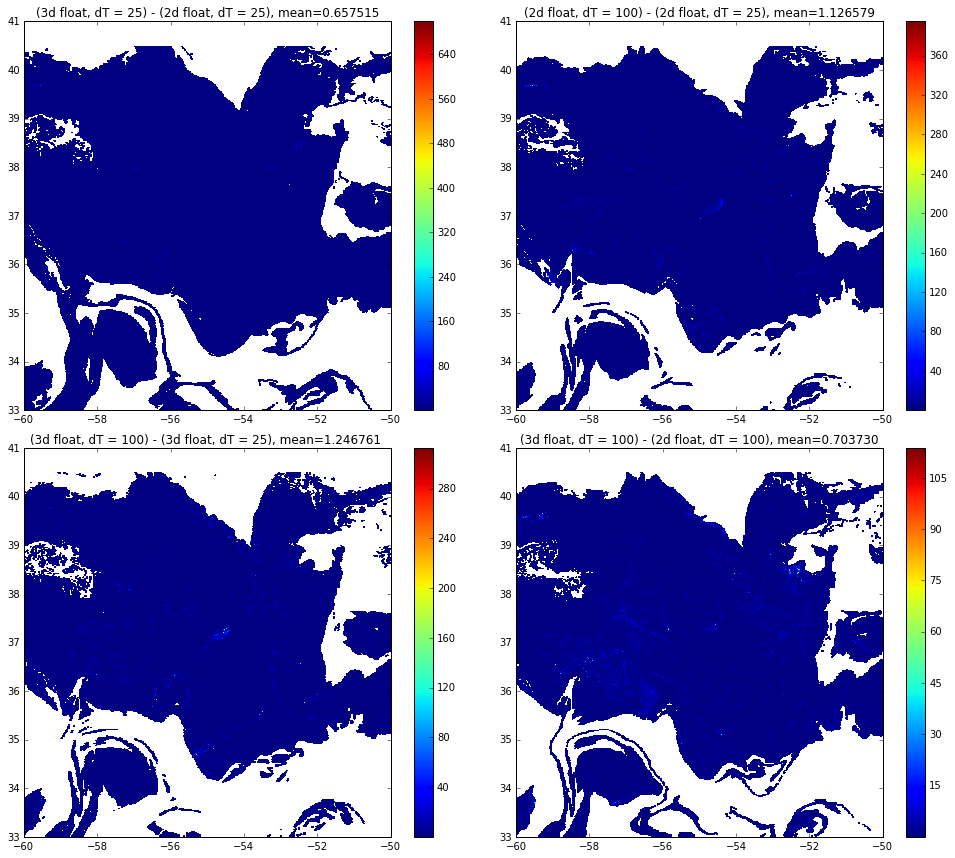

In [13]:
fig = plt.figure(figsize=(14,12))

plt.subplot(2,2,1)
plt.pcolormesh(x0,y0,np.ma.masked_array(error_flowmap_1,lav_mask_1))#, cmap = 'winter_r');
plt.title('(%s) - (%s), mean=%f' %(cases[1], cases[0], np.mean(np.ma.masked_array(error_flowmap_1,lav_mask_1))))
#plt.clim([-800000.0,800000.0])
plt.colorbar()

plt.subplot(2,2,2)
plt.pcolormesh(x0,y0,np.ma.masked_array(error_flowmap_2,lav_mask_2))#, cmap = 'winter_r');
plt.title('(%s) - (%s), mean=%f' %(cases[2], cases[0], np.mean(np.ma.masked_array(error_flowmap_2,lav_mask_2))))
#plt.clim([-800000.0,800000.0])
plt.colorbar()

plt.subplot(2,2,3)
plt.pcolormesh(x0,y0,np.ma.masked_array(error_flowmap_5,lav_mask_5))#, cmap = 'winter_r');
plt.title('(%s) - (%s), mean=%f ' %(cases[3], cases[1], np.mean(np.ma.masked_array(error_flowmap_5,lav_mask_5))))
#plt.clim([-800000.0,800000.0])
plt.colorbar()


plt.subplot(2,2,4)
plt.pcolormesh(x0,y0,np.ma.masked_array(error_flowmap_6,lav_mask_6))#, cmap = 'winter_r');
plt.title('(%s) - (%s), mean=%f' %(cases[3], cases[2], np.mean(np.ma.masked_array(error_flowmap_6,lav_mask_6))))
#plt.clim([-800000.0,800000.0])
plt.colorbar()

plt.tight_layout()
fig.savefig(figdir+'Fl_map_diff_normalized_between_cases_wo_same_clim')

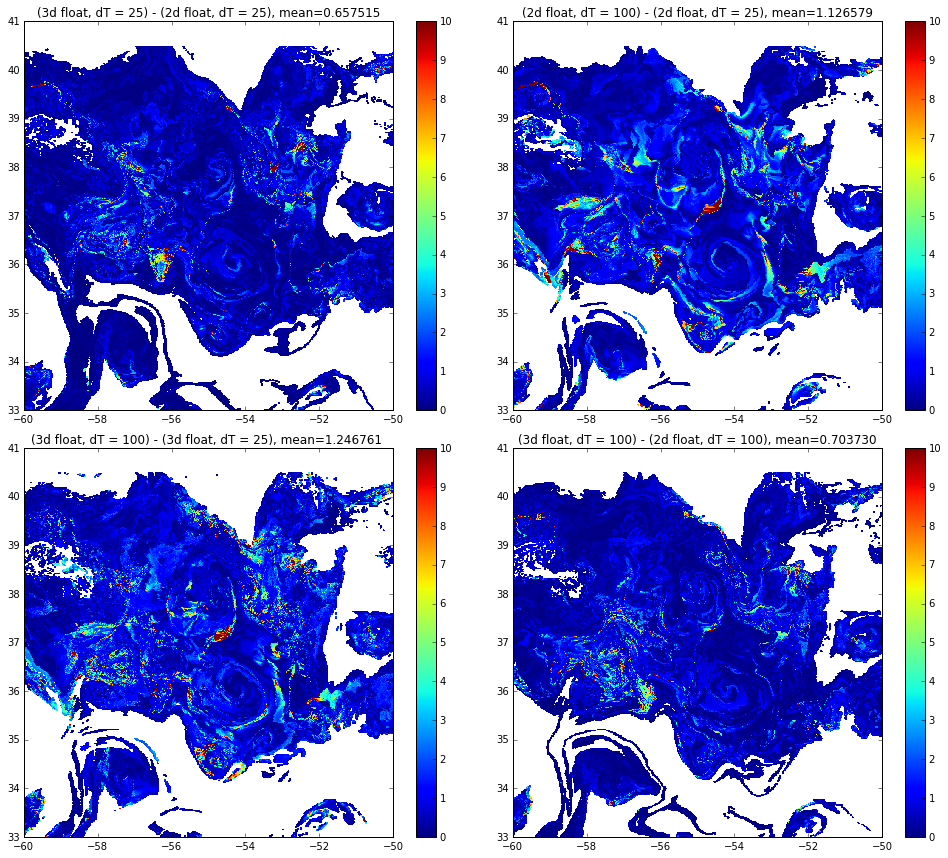

In [14]:
fig = plt.figure(figsize=(14,12))

plt.subplot(2,2,1)
plt.pcolormesh(x0,y0,np.ma.masked_array(error_flowmap_1,lav_mask_1))#, cmap = 'winter_r');
plt.title('(%s) - (%s), mean=%f' %(cases[1], cases[0], np.mean(np.ma.masked_array(error_flowmap_1,lav_mask_1))))
plt.clim([0.0,10.0])
plt.colorbar()

plt.subplot(2,2,2)
plt.pcolormesh(x0,y0,np.ma.masked_array(error_flowmap_2,lav_mask_2))#, cmap = 'winter_r');
plt.title('(%s) - (%s), mean=%f' %(cases[2], cases[0], np.mean(np.ma.masked_array(error_flowmap_2,lav_mask_2))))
plt.clim([0.0,10.0])
plt.colorbar()

plt.subplot(2,2,3)
plt.pcolormesh(x0,y0,np.ma.masked_array(error_flowmap_5,lav_mask_5))#, cmap = 'winter_r');
plt.title('(%s) - (%s), mean=%f ' %(cases[3], cases[1], np.mean(np.ma.masked_array(error_flowmap_5,lav_mask_5))))
plt.clim([0.0,10.0])
plt.colorbar()


plt.subplot(2,2,4)
plt.pcolormesh(x0,y0,np.ma.masked_array(error_flowmap_6,lav_mask_6))#, cmap = 'winter_r');
plt.title('(%s) - (%s), mean=%f' %(cases[3], cases[2], np.mean(np.ma.masked_array(error_flowmap_6,lav_mask_6))))
plt.clim([0.0,10.0])
plt.colorbar()

plt.tight_layout()
fig.savefig(figdir+'Fl_map_diff_normalized_between_cases_w_same_clim')

In [15]:
Error_deltaF_1 = np.ma.masked_array(error_flowmap_1,lav_mask_1)
Error_deltaF_2 = np.ma.masked_array(error_flowmap_2,lav_mask_2)
Error_deltaF_3 = np.ma.masked_array(error_flowmap_3,lav_mask_3)
Error_deltaF_4 = np.ma.masked_array(error_flowmap_4,lav_mask_4)
Error_deltaF_5 = np.ma.masked_array(error_flowmap_5,lav_mask_5)
Error_deltaF_6 = np.ma.masked_array(error_flowmap_6,lav_mask_6)


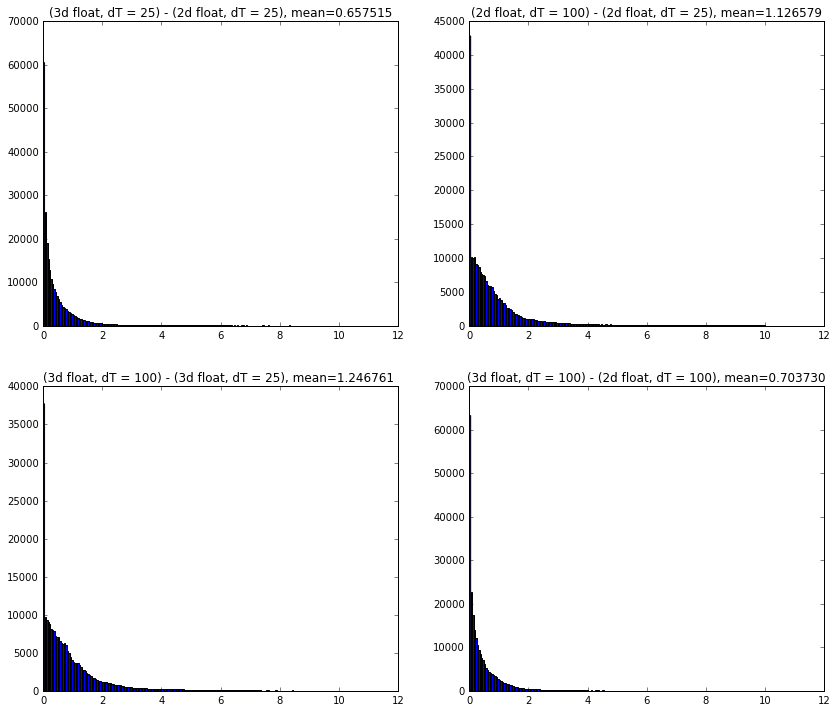

In [17]:
fig = plt.figure(figsize=(14,12))
plt.subplot(221)
plt.hist(error_flowmap_1.ravel(), range=(0,10), bins=200);
plt.title('(%s) - (%s), mean=%f' %(cases[1], cases[0], np.mean(np.ma.masked_array(error_flowmap_1,lav_mask_1))))
plt.subplot(222)
plt.hist(error_flowmap_2.ravel(), range=(0,10), bins=200);
plt.title('(%s) - (%s), mean=%f' %(cases[2], cases[0], np.mean(np.ma.masked_array(error_flowmap_2,lav_mask_2))))
plt.subplot(223)
plt.hist(error_flowmap_5.ravel(), range=(0,10), bins=200);
plt.title('(%s) - (%s), mean=%f ' %(cases[3], cases[1], np.mean(np.ma.masked_array(error_flowmap_5,lav_mask_5))))
plt.subplot(224)
plt.hist(error_flowmap_6.ravel(), range=(0,10), bins=200);
plt.title('(%s) - (%s), mean=%f' %(cases[3], cases[2], np.mean(np.ma.masked_array(error_flowmap_6,lav_mask_6))))

fig.savefig(figdir + 'Fl_map_diff_normalized_histogram')

# Particle by particle tracking #

Here we try to find absolute diffusivity by first trying to calculate the initial and final position of each particle. 

In [19]:
testdir = '/data/scratch/as4479/llc_run_s_2/trajectories_fewer_fields.bcolz/'

In [20]:
bc = bcolz.open(rootdir=testdir)
df = bc.todataframe()

In [21]:
df.head()

,npart,time,x,y,vort
0,13398,0,-52.044998,33.397499,-999
1,13399,0,-52.025002,33.397499,-999
2,13400,0,-52.005001,33.397499,-999
3,13401,0,-51.985001,33.397499,-999
4,13402,0,-51.965000,33.397499,-999


In [22]:
ds = xr.Dataset(df)
ds

<xarray.Dataset>
Dimensions:  (dim_0: 8750000)
Coordinates:
  * dim_0    (dim_0) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
Data variables:
    npart    (dim_0) float32 13398.0 13399.0 13400.0 13401.0 13402.0 13403.0 ...
    time     (dim_0) float32 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    x        (dim_0) float32 -52.045 -52.025 -52.005 -51.985 -51.965 -51.945 ...
    y        (dim_0) float32 33.3975 33.3975 33.3975 33.3975 33.3975 33.3975 ...
    vort     (dim_0) float32 -999.0 -999.0 -999.0 -999.0 -999.0 -999.0 ...

In [ ]:
pd.MultiIndex.from_arrays([df.time, df.npart])